In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from iafCA import iafCA
import pygame
from physicsCA import min_max

pygame 2.0.1 (SDL 2.0.14, Python 3.9.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] + 5.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] - 0.2
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), 7)
    
    return cdim_order

# Init CA

In [3]:
RADIUS=20
ca = iafCA(RADIUS=RADIUS).cuda() 

(-0.5, 40.5, 40.5, -0.5)

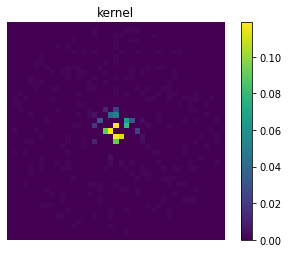

In [4]:
plt.imshow(ca.rule.nearest_neighbours.data[0, 0].cpu().numpy())
plt.colorbar()
plt.title('kernel')
plt.axis('off')

In [5]:
# brush properties
r = 20
s = 1

### Init Webcam

This notebook uses your webcam to inject video into the voltages of the spiking network. If you don't have a working webcam, this will throw an error. You can avoid the error by commenting this cell and uncommenting the dummy array cell below.

In [6]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
ret, frame = cap.read()
frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [7]:
#### dummy array if no webcam ####
# frame = np.zeros((10, 10))

The cell below initializes a pygame window to run the CA. This window is interactive.


left/right click: to add or remove voltage.

scroll wheel: rotate through the different channels in the simulation. The order is [Spikes, Voltages, Refractory Time, Traces, Threshold, Energy, Excitatory/Inhibitory labels].

scroll click: resets the view to the spike channel

"[" or "]": decrease/increase the intensity of the injected webcam image.

down/up arrows: decrease/increase kernel strength

r: reset CA state

k: reinitialize the kernel

p: pause the simulation

e: toggle saving/unsaving frames. To use, press "e" once to start saving images, and press "e" again to stop. When you close the pygame window, the very last cell in this notebook generates a video using these saved frames.

w: toggle injecting webcame

s: toggle sink (doesn't really work at the moment but can easily be changed. See "if sink:" condition in the cell below.



In [8]:
# resolution of grid
RESX= 640
RESY= 480

state = ca.initGrid((RESX, RESY))
og_kernel = ca.rule.nearest_neighbours
kernel_scale = 1.
kernel_increment = .2
update_rate = 1.

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
screen = pygame.Surface(size)
UPSCALE = 2
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])
######################################

# webcam stuff
######################################
inject_webcam = False
wbcam_fy = RESY / frame.shape[0]
wbcam_fx = wbcam_fy
img_norm = 1/255. 
######################################

# more pygame/initialization stuff
######################################
running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, 6)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.5
            if event.type == pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.5
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    

            if event.type == pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.nearest_neighbours = ca.rule.generate_cppn_kernel() 
                og_kernel = ca.rule.nearest_neighbours
            if event.type == pygame.KEYDOWN and event.key == pygame.K_UP:
                kernel_scale += kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_DOWN:
                kernel_scale -= kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_w:
                inject_webcam = not inject_webcam
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid((RESX, RESY))
                
                    
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
            
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False
        
        # nx is the array that will be visualized by pygame.
        
        # nx = state.cpu()[:, cdim_order].numpy()[0, 0, :, :].transpose(1, 2, 0)
        # nx = state.cpu().numpy()[0, cdim_order[0], :, :]
        # nx = state.cpu().numpy()[0, [0, 1, 5], :, :].transpose(1, 2, 0)
        # nx = state.cpu()[0, cdim_order].numpy().transpose(1, 2, 0)
        nx = state[0, cdim_order[0], :, :].cpu().numpy()
        # nx = state[0, [0, 1, -2], :, :]
        # nx = np.stack([min_max(np.log10(1 + c)) for c in nx], axis=-1) * 255.
        nx = nx * 255.
        
        ### FORWARD PASS ###
        if time_ticking:
            state = ca.forward(state)
            ticker += 1
            
            if inject_webcam:
                ret, frame = cap.read()
                frame = cv2.resize(frame, None, fx=wbcam_fx, fy=wbcam_fy, interpolation=cv2.INTER_AREA)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()
                frame = torch.cuda.FloatTensor(frame) * img_norm * update_rate
                state[0, 1, 0:frame.shape[0], 0:frame.shape[1]] = state[0, 1, 0:frame.shape[0], 0:frame.shape[1]] + frame
                # state[0, 4, 0:frame.shape[0], 0:frame.shape[1]] = state[0, 4, 0:frame.shape[0], 0:frame.shape[1]] - 0.5 * frame
                
    
            if sink:
                xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
                X, Y = torch.meshgrid(xv, yv)
                amp = 0.00
                w = 30
                R = torch.sqrt(X**2 + Y**2).cuda()
                state[0, 1] = torch.where(R > 0.5, state[0, 1] - 2 * torch.ones_like(state[0, 1]).cuda(), state[0, 1])

            if export_imgs:
                imgs.append(nx)
                # imgs.append(state[0, [0, 1, 4, 5], ...].cpu().numpy())
        ####################

        pygame.surfarray.blit_array(screen, nx)        
        py_frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(py_frame, py_frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        pygame.display.flip()
        clock.tick(60)
        
pygame.quit()


Plot some statistics from the last frame (generally use this for sanity checks).

Text(0.5, 1.0, 'Energy')

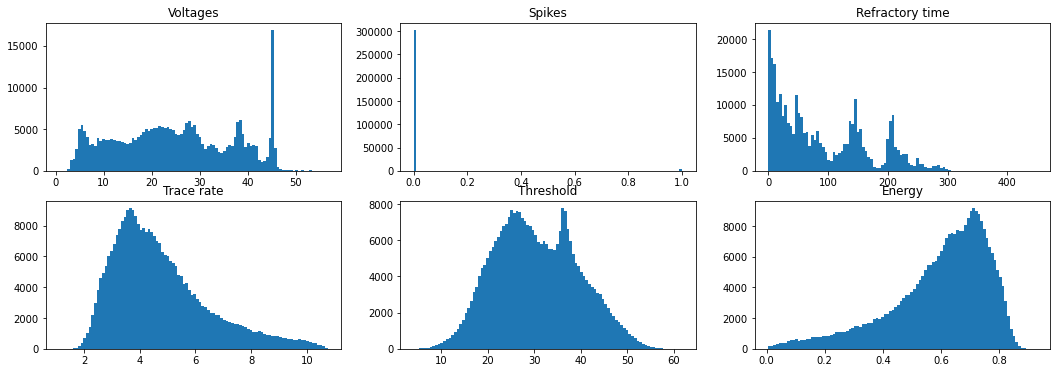

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes = axes.flatten()

axes[0].hist(state[0, 1].cpu().numpy().reshape(-1), 100);
axes[0].set_title('Voltages')
axes[1].hist(state[0, 0].cpu().numpy().reshape(-1), 100);
axes[1].set_title('Spikes')
axes[2].hist(state[0, 2].cpu().numpy().reshape(-1), 100);
axes[2].set_title('Refractory time')

axes[3].hist(state[0, 3].cpu().numpy().reshape(-1), 100)
axes[3].set_title('Trace rate')
axes[4].hist(state[0, 4].cpu().numpy().reshape(-1), 100)
axes[4].set_title('Threshold')
axes[5].hist(state[0, 5].cpu().numpy().reshape(-1), 100)
axes[5].set_title('Energy')

In [10]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 1)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
